In [ ]:
import torch

from learnedMethodForHologram import *
from learnedMethodForHologram.optics import bandLimitedAngularSpectrumMethod as BLASM_v1
from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod as BLASM_v2,
)

# about the data loader

In [ ]:
# convert the .exr data to torch tensors
data_processor.read_exr_in_multi_folders(
    "data\\test_192", channlesNum=3, height=192, width=192
)
data_processor.read_exr_in_multi_folders(
    "data\\test_384", channlesNum=3, height=384, width=384
)

In [ ]:
dataset = data_processor.data_loader(
    "data\\test_192\\amp.bin",
    "data\\test_192\\phs.bin",
    "data\\test_192\\img.bin",
    "data\\test_192\\depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
)

dataLoader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0
)

In [ ]:
amp, phs, img, depth = next(iter(dataLoader))
utilities.multi_channel_plotter(utilities.tensor_normalizor_2D(amp), torch.tensor(0.0), rgb_img=True)
utilities.multi_channel_plotter(utilities.tensor_normalizor_2D(phs), torch.tensor(0.0), rgb_img=True)
utilities.multi_channel_plotter(utilities.tensor_normalizor_2D(img), torch.tensor(0.0), rgb_img=True)
utilities.multi_channel_plotter(utilities.tensor_normalizor_2D(depth), torch.tensor(0.0), rgb_img=True)

In [ ]:
depth_np = depth.squeeze().numpy()
print(depth_np.max(), depth_np.min())

In [ ]:
import torch
from learnedMethodForHologram import *

dataset = data_processor.data_loader_img_depth(
    img_path = "data\\MIT_CGH_192_bin\\train\\img.bin",
    depth_path = "data\\MIT_CGH_192_bin\\train\\depth.bin",
    samplesNum=3800,
    channlesNum=3,
    height=192,
    width=192,
    padding=False,
    cuda=True,
)

dataLoader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)

%timeit img_depth_tensor = next(iter(dataLoader))
img_depth_tensor = next(iter(dataLoader))

print(f"the max value of the img is {img_depth_tensor[:,0].max()}")   


# about band_limited_angular_spectrum_method(V1)

In [ ]:
torch.cuda.empty_cache()

distances = torch.tensor(
    [0.0, 2.5e-2, 5.0e-3, 7.5e-3, 1.0e-2, 5.0e-2, 10.0e-2, 20.0e-3]
)
propagator = BLASM_v1(distances=distances)
%timeit propagator.band_limited_angular_spectrum_multichannels()

del(propagator)
torch.cuda.empty_cache()

In [ ]:
# clear the cache
torch.cuda.empty_cache()

distances = torch.linspace(0, 2.5e-3, 3)
propagator = BLASM_v1(distances=distances,band_limit=True)
g_z_complex = propagator.band_limited_angular_spectrum_multichannels()
intensity = utilities.intensity_calculator(g_z_complex, True)
utilities.multi_depth_plotter(utilities.tensor_normalizor_2D(intensity), distances, rgb_img=True)

# about band_limited_angular_spectrum_method(V2)

In [ ]:
from tests import *
test_bandlimited_agular_spectrum_approach.test()

## dataset_192

In [ ]:
import torch
from learnedMethodForHologram import *

dataset = data_processor.data_loader(
    "data\\MIT_CGH_192_bin\\train\\amp.bin",
    "data\\MIT_CGH_192_bin\\train\\phs.bin",
    "data\\MIT_CGH_192_bin\\train\\img.bin",
    "data\\MIT_CGH_192_bin\\train\\depth.bin",
    samplesNum=3800,
    channlesNum=3,
    height=192,
    width=192,
)

dataLoader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
sampleX = next(iter(dataLoader))

In [ ]:
amplitude_tensor = sampleX[0]
phase_tensor = sampleX[1]
distances = torch.linspace(-2e-4, 2e-4, 7)
# spacial_frequency_filter = (
#     utilities.generate_custom_frequency_mask(
#         sample_row_num=2400,
#         sample_col_num=4094,
#         x=800,
#         y=int(800 * 4094 / 2400),
#     )
# )
propagator = bandlimited_angular_spectrum_approach.bandLimitedAngularSpectrumMethod(
    sample_row_num=192,
    sample_col_num=192,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=False,
)
intensities = propagator(
    amplitute_tensor=amplitude_tensor,
    phase_tensor=phase_tensor,
    distances=distances,
    # spacial_frequency_filter=spacial_frequency_filter,
)
normalized_intensities = utilities.tensor_normalizor_2D(intensities)

utilities.multi_depth_plotter(
    normalized_intensities,
    distances,
    rgb_img=True,
    save_dir="output\\test_output\\blasm_v2_dataset_192",
    color=0,
)

## dataset_384

In [ ]:
import torch
from learnedMethodForHologram import *

dataset = data_processor.data_loader(
    "data\\MIT_CGH_384_bin\\test\\amp.bin",
    "data\\MIT_CGH_384_bin\\test\\phs.bin",
    "data\\MIT_CGH_384_bin\\test\\img.bin",
    "data\\MIT_CGH_384_bin\\test\\depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=384,
    width=384,
)

dataLoader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
sampleX = next(iter(dataLoader))

In [ ]:
amplitude_tensor = sampleX[0]
phase_tensor = sampleX[1]
distances = torch.linspace(-0.15e-4, 10e-4, 7)
# spacial_frequency_filter = (
#     utilities.generate_custom_frequency_mask(
#         sample_row_num=2400,
#         sample_col_num=4094,
#         x=800,
#         y=int(800 * 4094 / 2400),
#     )
# )
propagator = bandlimited_angular_spectrum_approach.bandLimitedAngularSpectrumMethod(
    sample_row_num=384,
    sample_col_num=384,
    pixel_pitch=8e-6,
    wave_length=torch.tensor([638e-9, 520e-9, 450e-9]),
    band_limit=False,
    cuda=False,
)
intensities = propagator(
    amplitute_tensor=amplitude_tensor,
    phase_tensor=phase_tensor,
    distances=distances,
    # spacial_frequency_filter=spacial_frequency_filter,
)
normalized_intensities = utilities.tensor_normalizor_2D(intensities)

utilities.multi_depth_plotter(
    normalized_intensities,
    distances,
    rgb_img=True,
    save_dir="output\\test_output\\blasm_v2_dataset_384",
    color=0,
)

# about BLASM_v2 and v3

In [ ]:
from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod as BLASM_v2,
)
from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod_for_single_fixed_distance as BLASM_v3,
)

propagator_v2 = BLASM_v2(
    sample_row_num=192,
    sample_col_num=192,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=False,
)

w_grid_v2 = propagator_v2.generate_w_grid()
transfer_function_v2 = propagator_v2.generate_transfer_function(distances=torch.tensor([2.5e-3]))
print(transfer_function_v2.shape)

propagator_v3 = BLASM_v3(
    sample_row_num=192,
    sample_col_num=192,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=False,
    distance=torch.tensor([2.5e-3]),
)

w_grid_v3 = propagator_v3.generate_w_grid()
transfer_function_v3 = propagator_v3.generate_transfer_function()
print(transfer_function_v3.shape)

assert torch.allclose(w_grid_v2, w_grid_v3)
assert torch.allclose(transfer_function_v2, transfer_function_v3)

## dataset_192 with padding

In [ ]:
import torch
from learnedMethodForHologram import *

dataset = data_processor.data_loader(
    "data\\MIT_CGH_192_bin\\train\\amp.bin",
    "data\\MIT_CGH_192_bin\\train\\phs.bin",
    "data\\MIT_CGH_192_bin\\train\\img.bin",
    "data\\MIT_CGH_192_bin\\train\\depth.bin",
    samplesNum=3800,
    channlesNum=3,
    height=192,
    width=192,
    padding=True, # padding the input data to 256x256
    cuda=False,
)

dataLoader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
sampleX = next(iter(dataLoader))

print(sampleX[0].shape)

In [ ]:
amplitude_tensor = sampleX[0]
phase_tensor = sampleX[1]
distances = torch.linspace(-1.5e-4, 1.5e-4, 7)
# spacial_frequency_filter = (
#     utilities.generate_custom_frequency_mask(
#         sample_row_num=2400,
#         sample_col_num=4094,
#         x=800,
#         y=int(800 * 4094 / 2400),
#     )
# )
propagator = bandlimited_angular_spectrum_approach.bandLimitedAngularSpectrumMethod(
    sample_row_num=512,
    sample_col_num=512,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=False,
)
intensities = propagator(
    amplitute_tensor=amplitude_tensor,
    phase_tensor=phase_tensor,
    distances=distances,
    # spacial_frequency_filter=spacial_frequency_filter,
)
normalized_intensities = utilities.tensor_normalizor_2D(intensities)

utilities.multi_depth_plotter(
    normalized_intensities,
    distances,
    rgb_img=True,
    save_dir="output\\test_output\\blasm_v2_dataset_192_padding_512",
    color=0,
)

# model training

In [ ]:
import torch
from learnedMethodForHologram import (
    neural_network,
    bandlimited_angular_spectrum_approach,
)

propagator = bandlimited_angular_spectrum_approach.bandLimitedAngularSpectrumMethod(
    sample_row_num=192,
    sample_col_num=192,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=False,
)

amps = torch.randn(4, 3, 192, 192)
phs = torch.randn(4, 3, 192, 192)

intensities = propagator(amps, phs, torch.tensor([0.0]))
print(f"intensities shape: {intensities.shape}")

amps = torch.randn(1, 3, 192, 192)
phs = torch.randn(1, 3, 192, 192)

intensities = propagator(amps, phs, torch.tensor([0.0]))
print(f"intensities shape: {intensities.shape}")

amps_phs = torch.randn(1, 6, 192, 192)

amp_phs = propagator.propagate_AP2AP(amps_phs, torch.tensor([0.0]))
print(f"propagate_AP2AP shape: {amp_phs.shape}")

amps = torch.randn(1, 3, 192, 192)
phs = torch.randn(1, 3, 192, 192)

intensities = propagator.propagate_P2I(phs, torch.tensor([0.0]))
print(f"propagate_P2I shape: {intensities.shape}")

amps_phs = torch.randn(4, 6, 192, 192)

amp_phs = propagator.propagate_AP2AP(amps_phs, torch.tensor([0.0]))
print(f"propagate_AP2AP shape: {amp_phs.shape}")

intensities = propagator.propagate_P2I(phs, torch.tensor([0.0]))
print(f"propagate_P2I shape: {intensities.shape}")

tensor1 = torch.randn(4, 4, 192, 192)
model = neural_network.UNet()
output = model(tensor1)
print(f"output shape of the UNet: {output.shape}")

tensor2 = torch.randn(4, 2, 192, 192)
model = neural_network.ResNet_POH()
output = model(tensor2)
print(f"output shape of the ResNet_POH: {output.shape}")

In [ ]:
import torch
from learnedMethodForHologram import (
    neural_network,
    bandlimited_angular_spectrum_approach,
)

propagator = bandlimited_angular_spectrum_approach.bandLimitedAngularSpectrumMethod_for_single_fixed_distance(
    sample_row_num=192,
    sample_col_num=192,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=False,
    distance=torch.tensor([0.0]),
)

amps = torch.randn(4, 3, 192, 192)
phs = torch.randn(4, 3, 192, 192)

intensities = propagator(amps, phs)
print(f"intensities shape: {intensities.shape}")

amps = torch.randn(1, 3, 192, 192)
phs = torch.randn(1, 3, 192, 192)

intensities = propagator(amps, phs)
print(f"intensities shape: {intensities.shape}")

amps_phs = torch.randn(1, 6, 192, 192)

amp_phs = propagator.propagate_AP2AP(amps_phs)
print(f"propagate_AP2AP shape: {amp_phs.shape}")

amps = torch.randn(1, 3, 192, 192)
phs = torch.randn(1, 3, 192, 192)

intensities = propagator.propagate_P2I(phs)
print(f"propagate_P2I shape: {intensities.shape}")

amps_phs = torch.randn(4, 6, 192, 192)

amp_phs = propagator.propagate_AP2AP(amps_phs)
print(f"propagate_AP2AP shape: {amp_phs.shape}")

intensities = propagator.propagate_P2I(phs)
print(f"propagate_P2I shape: {intensities.shape}")

tensor1 = torch.randn(4, 4, 192, 192)
model = neural_network.UNet()
output = model(tensor1)
print(f"output shape of the UNet: {output.shape}")

tensor2 = torch.randn(4, 2, 192, 192)
model = neural_network.ResNet_POH()
output = model(tensor2)
print(f"output shape of the ResNet_POH: {output.shape}")

In [ ]:
model = neural_network.UNet()
model.eval()
%timeit output = model(tensor1)

model = neural_network.ResNet_POH()
%timeit output = model(tensor2)

In [ ]:
import torch
from learnedMethodForHologram.data_processor import data_loader_img_depth
from learnedMethodForHologram.neural_network import watermelon

batch_num = 4
dataset = data_loader_img_depth(
    img_path="data\\MIT_CGH_192_bin\\train\\img.bin",
    depth_path="data\\MIT_CGH_192_bin\\train\\depth.bin",
    samplesNum=3800,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_num,
    shuffle=True,
    num_workers=0,
)

batch = next(iter(dataLoader))
model = watermelon(
    input_shape=batch.shape,
    propagation_distance=torch.tensor([2.5e-3]),
    cuda=True,
)
output = model(batch)

In [ ]:
import torch
from learnedMethodForHologram.data_processor import data_loader_img_depth
from learnedMethodForHologram.neural_network import watermelon

dataset_train = data_loader_img_depth(
    img_path="data\\MIT_CGH_192_bin\\test\\img.bin",
    depth_path="data\\MIT_CGH_192_bin\\test\\depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader_dataset_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

dataset_test = data_loader_img_depth(
    img_path="data\\MIT_CGH_192_bin\\validate\\img.bin",
    depth_path="data\\MIT_CGH_192_bin\\validate\\depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader_dataset_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

model = watermelon(
    input_shape=(1, 4, 192, 192),
    propagation_distance=torch.tensor([2.5e-3]),
    cuda=True,
)

model.train_model(
    train_iter=dataLoader_dataset_train,
    test_iter=dataLoader_dataset_test,
    num_epochs=10,
    lr=1e-2,
)

# save the model
torch.save(model.state_dict(), 'watermelon_v1.pth')

f:\anaconda\envs\FYP\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


output type: <class 'torch.Tensor'>
output shape: torch.Size([1, 3, 192, 192])
output max: 1.0436224937438965
output min: 0.016761289909482002


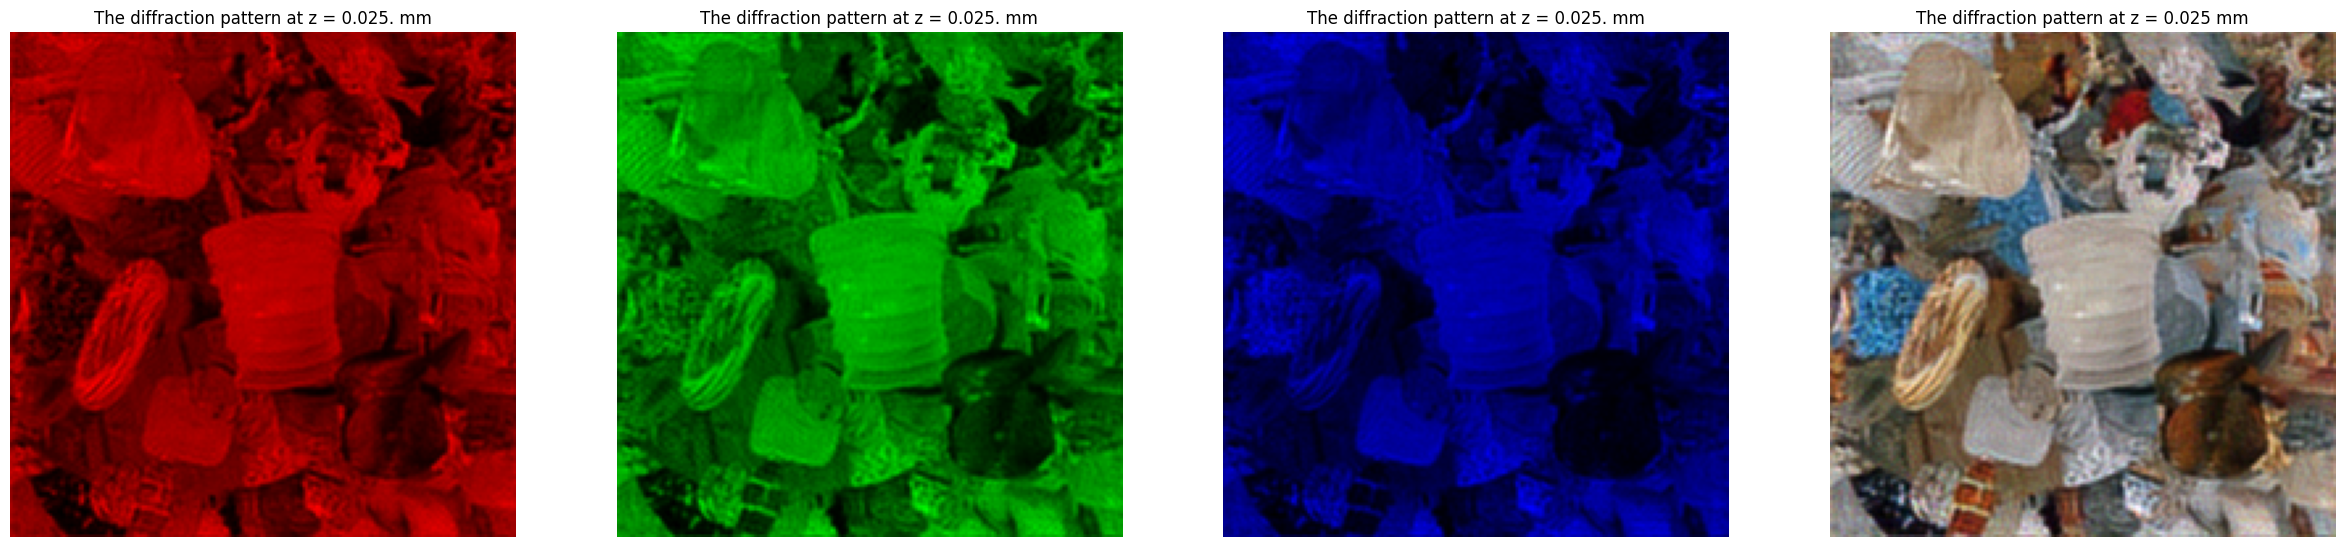

In [17]:
import torch
from learnedMethodForHologram import utilities
from learnedMethodForHologram.data_processor import data_loader_img_depth
from learnedMethodForHologram.neural_network import watermelon


# load the model
model = watermelon(
    input_shape=(1, 4, 192, 192),
    propagation_distance=torch.tensor([1e-3]),
    cuda=True,
)

model.load_state_dict(torch.load("output\\models\\watermelon_v2_trainedwith3800samples.pth"))
model.eval()

dataset_test = data_loader_img_depth(
    img_path="data\\MIT_CGH_192_bin\\test\\img.bin",
    depth_path="data\\MIT_CGH_192_bin\\test\\depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader_dataset_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

batch = next(iter(dataLoader_dataset_test))
output = model(batch).to("cpu").detach()
print(f"output type: {type(output)}")
print(f"output shape: {output.shape}")
print(f"output max: {output.max()}")
print(f"output min: {output.min()}")
utilities.multi_depth_plotter(
    utilities.tensor_normalizor_2D(output),
    torch.tensor([2.5e-2]),
    rgb_img=True,
)

In [14]:
from learnedMethodForHologram.utilities import gpu_timer

time = gpu_timer(lambda: model.part1(batch),repeat=1)

In [15]:
time

3340.69189453125

# drafts

In [ ]:
sample_row_num = 2400
sample_col_num = 4094
x = sample_row_num // 3
y = x * sample_col_num // sample_row_num
x, y

In [ ]:
tensorX = torch.rand(3,5,256,256)
tensor_192 = tensorX[
    ...,
    256//2 - 192//2 : 256//2 + 192//2,
    256//2 - 192//2 : 256//2 + 192//2,
]
print(tensor_192.shape)

In [ ]:
import torch
from learnedMethodForHologram import utilities
tensorX = torch.rand(3,5,256,256)
%timeit utilities.cut_center_256_192(tensorX).shape

In [ ]:
import torch

# 创建一个张量并启用梯度计算
x = torch.tensor(
    [[1.0, 2.0, 3.0], [3.0, 4.0, 5.0], [4.0, 5.0, 6.0]], requires_grad=True
)

# 对张量进行裁剪，并将裁剪的部分分离出计算图
y = x[:1, :].detach()

# 进行一些计算
z = y.sum() + x.sum()

# 反向传播
z.backward()

# 查看梯度
print(y.grad)  # 只有没有被分离的部分会有梯度

In [ ]:
import torch

# 创建一个张量并启用梯度计算
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]], requires_grad=True)

# 对张量进行裁剪，并将裁剪的部分分离出计算图
x = x[:1, :]
x.retain_grad()

# 进行一些计算
z = x.sum()

# 反向传播
z.backward()

# 查看梯度
print(x.grad)  # 只有没有被分离的部分会有梯度

In [ ]:
import torch

# 假设的行数和列数
samplingRowNum = 10
samplingColNum = 20

# 示例张量，假设形状为 (100, 3, 2, 10, 20)
amp_phs_tensor = torch.randn(100, 6, samplingRowNum, samplingColNum)

# 重新定义形状，并去除大小为1的维度
result_tensor = amp_phs_tensor.view(-1, 3, 2, samplingRowNum, samplingColNum)[
    :, :, 0
].squeeze()

print(result_tensor.shape)

In [ ]:
import torch

def custom_loss(output, target):
    # 计算每个像素的绝对差异
    loss = torch.mean(torch.abs(output - target))
    return loss

# 假设 batch_num 为 x，图像大小为 192x192，三通道
batch_num = 4
output = torch.randn(batch_num, 3, 192, 192)  # 模型输出
target = torch.randn(batch_num, 3, 192, 192)  # 目标图像

# 计算自定义损失
loss = custom_loss(output, target)
print(f'Custom Loss: {loss.item()}')


In [ ]:
x = torch.randn(4, 3, 192, 192)
y = x[:,:2]
print(y.shape)